In [1]:
import numpy as np
import pandas as pd
import os
np.object = object
np.bool = bool
np.int = int

In [2]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
adata = pd.read_csv("C:/Data/full_df.csv")


In [6]:
def can_apply(term,text):
    if term in text:
        return 1
    else:
        return 0

In [8]:
def process_dataset(data):
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: can_apply("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: can_apply("cataract",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: can_apply("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: can_apply("glaucoma",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: can_apply("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: can_apply("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: can_apply("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: can_apply("macular degeneration",x))
    
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
    
    left_normal_images = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(300,random_state=42).values
    right_normal_images = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(300,random_state=42).values

    left_glaucoma_images = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma_images = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    left_myopia_images = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia_images = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
    
    left_age_images = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age_images = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    normal = np.concatenate((left_normal_images,right_normal_images),axis = 0);
    cataract = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    glaucoma = np.concatenate((left_glaucoma_images,right_glaucoma_images),axis = 0);
    myopia = np.concatenate((left_myopia_images,right_myopia_images),axis = 0);
    age = np.concatenate((left_age_images,right_age_images),axis=0);
    
    return normal,cataract,glaucoma,myopia,age;

In [ ]:
normal , cataract , glaucoma , myopia , age = process_dataset(adata);

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "C:\Data\preprocessed_images"
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir,img);
        
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);
    
    return dataset;

In [ ]:
# Норма == 0
# Катаракта == 1
# Глаукома == 2
# Миопия == 3
# Возраст == 4


dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(glaucoma,2)
dataset = dataset_generator(myopia,3)
dataset = dataset_generator(age,4)


len(dataset)

100%|██████████| 551/551 [00:01<00:00, 338.27it/s]


5638

In [ ]:

train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.5)

y_train_cat = to_categorical(y_train,num_classes=5)

y_test_cat = to_categorical(y_test,num_classes = 5)

Создание модели

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(5,activation="softmax"))

model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_20 (Flatten)        (None, 25088)             0         
                                                                 
 dense_60 (Dense)            (None, 256)               6422784   
                                                                 
 batch_normalization_40 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_61 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_41 (Bat  (None, 256)              1024      
 chNormalization)                                    

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit(x_train,y_train_cat,batch_size=64,epochs=11)
print(history)

Epoch 1/11
45/45 [==============================] - 232s 5s/step - loss: 0.7646 - accuracy: 0.7237
Epoch 2/11
45/45 [==============================] - 239s 5s/step - loss: 0.2533 - accuracy: 0.9127
Epoch 3/11
45/45 [==============================] - 249s 6s/step - loss: 0.1557 - accuracy: 0.9631
Epoch 4/11
45/45 [==============================] - 259s 6s/step - loss: 0.1227 - accuracy: 0.9642
Epoch 5/11
45/45 [==============================] - 268s 6s/step - loss: 0.1107 - accuracy: 0.9681
Epoch 6/11
45/45 [==============================] - 265s 6s/step - loss: 0.1091 - accuracy: 0.9691
Epoch 7/11
45/45 [==============================] - 265s 6s/step - loss: 0.0879 - accuracy: 0.9762
Epoch 8/11
45/45 [==============================] - 264s 6s/step - loss: 0.0788 - accuracy: 0.9769
Epoch 9/11
45/45 [==============================] - 262s 6s/step - loss: 0.0717 - accuracy: 0.9784
Epoch 10/11
45/45 [==============================] - 264s 6s/step - loss: 0.0967 - accuracy: 0.9713
Epoch 11/

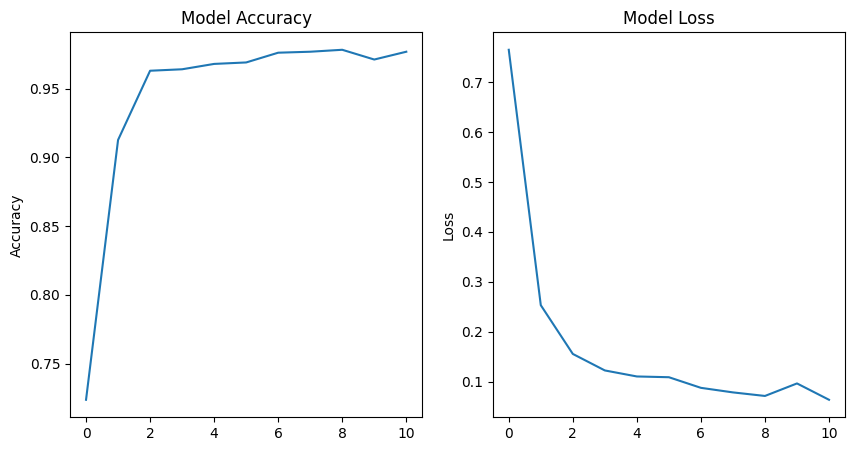

In [ ]:
import matplotlib.pyplot as plt

# Plot all metrics
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(model.history.history['accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set(ylabel='Accuracy')

axs[1].plot(model.history.history['loss'])
axs[1].set_title('Model Loss')
axs[1].set(ylabel='Loss')


plt.show()

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test_cat)
print("Accuracy:",accuracy)

89/89 [==============================] - 251s 3s/step - loss: 0.3160 - accuracy: 0.9230
Accuracy: 0.9230223298072815


In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred = []
for i in model.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

print(y_pred)

89/89 [==============================] - 232s 3s/step
[3, 0, 2, 2, 2, 2, 2, 3, 3, 0, 0, 1, 0, 3, 1, 1, 1, 2, 3, 3, 1, 3, 3, 3, 0, 0, 0, 0, 1, 4, 3, 1, 0, 4, 1, 1, 2, 4, 3, 4, 0, 3, 2, 2, 3, 0, 1, 1, 2, 3, 3, 2, 1, 2, 1, 4, 2, 2, 4, 4, 4, 1, 2, 0, 1, 4, 2, 0, 4, 2, 3, 1, 4, 0, 1, 0, 3, 0, 1, 0, 1, 4, 0, 0, 3, 2, 2, 2, 2, 3, 3, 2, 4, 1, 4, 1, 3, 3, 4, 1, 1, 3, 2, 3, 3, 0, 4, 1, 3, 4, 4, 2, 3, 1, 1, 3, 2, 4, 1, 3, 4, 2, 0, 4, 2, 3, 4, 4, 1, 2, 4, 0, 4, 0, 4, 4, 2, 1, 4, 3, 4, 4, 4, 1, 3, 2, 1, 2, 2, 0, 0, 3, 4, 4, 0, 1, 0, 0, 3, 2, 2, 3, 1, 2, 3, 0, 1, 3, 0, 0, 1, 3, 1, 2, 0, 4, 2, 3, 3, 4, 2, 3, 4, 3, 4, 2, 1, 0, 2, 3, 0, 2, 2, 2, 3, 1, 0, 2, 2, 0, 1, 0, 2, 4, 3, 1, 1, 3, 4, 0, 4, 2, 0, 2, 0, 0, 0, 4, 1, 1, 3, 3, 2, 3, 0, 3, 2, 1, 1, 3, 3, 0, 3, 0, 3, 4, 1, 2, 1, 2, 4, 1, 0, 3, 4, 2, 4, 2, 3, 2, 3, 2, 3, 1, 2, 0, 0, 4, 4, 3, 2, 3, 1, 2, 1, 3, 4, 2, 0, 1, 3, 2, 4, 1, 2, 1, 0, 3, 2, 4, 0, 3, 4, 0, 1, 0, 2, 3, 4, 4, 1, 2, 4, 4, 0, 0, 4, 4, 0, 0, 3, 1, 2, 3, 4, 1, 2, 0, 3, 4, 2, 2, 2, 0, 0, 

In [ ]:
print(accuracy_score(y_test,y_pred))

0.9230223483504789


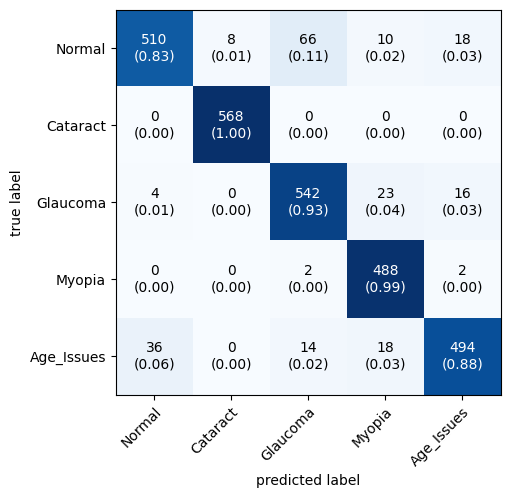

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(5,5),class_names = ["Normal","Cataract","Glaucoma","Myopia","Age_Issues"],show_normed = True);

In [ ]:
from tensorflow.keras.models import load_model

model.save('C:\Data\ModelEyes.h5')
